# LunarLander DQN Training

Interactive training notebook with configurable hyperparameters.

In [36]:
import gymnasium as gym
from src.envs.make_env import make_env
from src.agents.epsilon_greedy_agent import EpsilonGreedyAgent
from src.networks.q_network import QNetwork
from src.replay.replay_buffer import ReplayBuffer
from src.training.DQN_trainer import Trainer as DQNTrainer
from src.training.DDQN_trainer import Trainer as DDQNTrainer
import matplotlib.pyplot as plt
import numpy as np


## Hyperparameters Configuration

Modify these values to tune the training process:

In [37]:
# ============ TRAINING HYPERPARAMETERS ============
# Model Selection
model_type = 'DDQN'  # 'DQN' or 'DDQN' - Choose which algorithm to use

# Environment
num_episodes = 800  # Total number of training episodes
log_interval = 20  # Print stats every N episodes

# Training
train_every = 4  # Training step every N environment steps
batch_size = 64
learning_rate = 0.0001
gamma = 0.99  # Discount factor
replay_buffer_size = 50000  # Maximum size of the replay buffer

# Target Network Update
update_mode = 'hard'  # 'soft' for soft update every step, 'hard' for hard update every N steps
tau = 1e-3  # Soft update rate (used only if update_mode='soft')
target_update_freq = 10  # Hard update frequency (used only if update_mode='hard')

# Exploration
epsilon_starting_value = 1  # Initial exploration rate
epsilon_ending_value = 0.01   # Final exploration rate
epsilon_decay_value = 0.995   # Decay factor per episode

## Initialize Components

In [ ]:
# Initialize Q-Network with dropout
q_network = QNetwork(input_size=8, output_size=4, dropout_rate=dropout_rate)
print(f"🧠 Q-Network initialized with dropout_rate={dropout_rate}")

# Initialize epsilon from config
epsilon = epsilon_starting_value

# Initialize agent
agent = EpsilonGreedyAgent(action_space=4, q_network=q_network, epsilon=epsilon)

# Initialize replay buffer
replay_buffer = ReplayBuffer(max_size=replay_buffer_size)

# Initialize trainer based on model_type selection
if model_type == 'DQN':
    trainer = DQNTrainer(
        q_network, 
        learning_rate=learning_rate, 
        replay_buffer=replay_buffer, 
        gamma=gamma,
        update_mode=update_mode,
        tau=tau,
        target_update_freq=target_update_freq
    )
    print(f"🔵 Using DQN Trainer (classic DQN with max over target network)")
elif model_type == 'DDQN':
    trainer = DDQNTrainer(
        q_network, 
        learning_rate=learning_rate, 
        replay_buffer=replay_buffer, 
        gamma=gamma,
        update_mode=update_mode,
        tau=tau,
        target_update_freq=target_update_freq
    )
    print(f"🟢 Using Double DQN Trainer (action selection: online, evaluation: target)")
else:
    raise ValueError(f"Invalid model_type: {model_type}. Must be 'DQN' or 'DDQN'")

# Create environment
env = make_env(render_mode="rgb_array")

🟢 Using Double DQN Trainer (action selection: online, evaluation: target)


In [ ]:
import csv
import os
import pandas as pd
from src.training.episode_outcome import categorize_episode_outcome, get_outcome_icon

# ===== AUTO-INCREMENT RUN ID =====
configs_file = 'runs/all_configs_combined.csv'
runs_file = 'runs/all_runs_combined.csv'

# Read existing configs to find last run_id
df_configs = pd.read_csv(configs_file, dtype={'run_id': str})
last_run_id = df_configs['run_id'].astype(int).max()
new_run_id = str(last_run_id + 1).zfill(2)

print(f"📋 Last run_id found: {last_run_id:02d}")
print(f"🆕 New run_id: {new_run_id}")

# ===== APPEND NEW CONFIG TO all_configs_combined.csv =====
new_config = {
    'run_id': new_run_id,
    'model_type': model_type,
    'dropout_rate': dropout_rate,
    'num_episodes': num_episodes,
    'log_interval': log_interval,
    'train_every': train_every,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'gamma': gamma,
    'update_mode': update_mode,
    'tau': tau,
    'target_update_freq': target_update_freq,
    'replay_buffer_size': replay_buffer_size,
    'epsilon_starting_value': epsilon_starting_value,
    'epsilon_ending_value': epsilon_ending_value,
    'epsilon_decay_value': epsilon_decay_value
}

# Append to configs file
new_config_df = pd.DataFrame([new_config])
new_config_df.to_csv(configs_file, mode='a', header=False, index=False)
print(f"✅ Config appended to {configs_file}")

# ===== SETUP LOG FILE =====
run_list_dir = 'runs/run_list'
os.makedirs(run_list_dir, exist_ok=True)
log_file = f'{run_list_dir}/run{new_run_id}.csv'

with open(log_file, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['episode', 'reward', 'length', 'terminated', 'truncated', 'outcome'])

print(f"📁 Log file created: {log_file}")

📋 Last run_id found: 21
🆕 New run_id: 22
✅ Config appended to runs/all_configs_combined.csv
📁 Log file created: runs/run_list/run22.csv


## Training Loop with Visualization

In [40]:
# Training loop with episode outcome logging
episode_rewards = []
training_steps = 0
episode_outcomes = []
episode_logs = []  # Store logs for appending to combined file

print(f"🚀 Starting training for Run {new_run_id}...\n")

for episode in range(num_episodes):
    obs, info = env.reset()
    total_reward = 0.0
    terminated = False
    truncated = False
    episode_length = 0
    final_obs = obs
    last_step_reward = 0.0  # keep last reward of the episode

    while not (terminated or truncated):
        # Ask agent for action
        action = agent.act(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # store last step reward (used for outcome classification)
        last_step_reward = reward

        # Store transition in replay buffer
        done = terminated or truncated
        replay_buffer.add(obs, action, reward, next_obs, done)

        # Training step: sample batch and update network
        if training_steps % train_every == 0:
            loss = trainer.train_step(batch_size=batch_size)

        training_steps += 1
        total_reward += reward
        episode_length += 1
        obs = next_obs
        final_obs = next_obs

    episode_rewards.append(total_reward)

    # Categorize episode outcome
    outcome = categorize_episode_outcome(final_obs, episode_length, last_step_reward)
    episode_outcomes.append(outcome)

    # Store log entry
    log_entry = {
        'run_id': new_run_id,
        'episode': episode + 1,
        'reward': round(total_reward, 2),
        'length': episode_length,
        'terminated': int(terminated),
        'truncated': int(truncated),
        'outcome': outcome
    }
    episode_logs.append(log_entry)

    # Log to individual run CSV file
    with open(log_file, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([episode + 1, f"{total_reward:.2f}", episode_length,
                         int(terminated), int(truncated), outcome])

    # Decay epsilon after each episode
    epsilon = max(epsilon_ending_value, epsilon * epsilon_decay_value)
    agent.set_epsilon(epsilon)

    # Print individual episode result
    outcome_icon = get_outcome_icon(outcome)
    print(
        f"Episode {episode + 1:4d} | Steps: {episode_length:4d} | Reward: {total_reward:7.2f} | "
        f"{outcome_icon} {outcome.replace('_', ' ').title()} | ε: {epsilon:.4f}"
    )

    # Log average reward every N episodes
    if (episode + 1) % log_interval == 0:
        avg_reward = sum(episode_rewards[-log_interval:]) / log_interval

        # Count outcomes in recent window
        recent_outcomes = episode_outcomes[-log_interval:]
        outcome_counts = {
            'success': recent_outcomes.count('landed_success'),
            'crashed': recent_outcomes.count('crashed'),
            'out_of_bounds': recent_outcomes.count('out_of_bounds'),
            'time_limit': recent_outcomes.count('time_limit')
        }

        print(
            f"  └─ Avg Reward: {avg_reward:7.3f} | "
            f"Success: {outcome_counts['success']}, "
            f"Crashed: {outcome_counts['crashed']}, "
            f"Out of bounds: {outcome_counts['out_of_bounds']}, "
            f"Time limit: {outcome_counts['time_limit']}"
        )
        print()

env.close()

# ===== APPEND LOGS TO all_runs_combined.csv =====
logs_df = pd.DataFrame(episode_logs)
logs_df.to_csv(runs_file, mode='a', header=False, index=False)
print(f"✅ Logs appended to {runs_file}")

print(f"\n✅ Training completed for Run {new_run_id}!")
print(f"Total episodes: {num_episodes}")
print(f"Replay buffer size: {len(replay_buffer)} transitions")
print(f"Total training steps: {training_steps}")
print(f"Final epsilon: {epsilon:.4f}")

# Final statistics
success_count = episode_outcomes.count('landed_success')
crashed_count = episode_outcomes.count('crashed')
out_of_bounds_count = episode_outcomes.count('out_of_bounds')
time_limit_count = episode_outcomes.count('time_limit')

print(f"\n📊 Episode Outcomes:")
print(f"  🚀 Landed successfully: {success_count} ({100*success_count/num_episodes:.1f}%)")
print(f"  💥 Crashed: {crashed_count} ({100*crashed_count/num_episodes:.1f}%)")
print(f"  📍 Out of bounds: {out_of_bounds_count} ({100*out_of_bounds_count/num_episodes:.1f}%)")
print(f"  ⏱️  Time limit: {time_limit_count} ({100*time_limit_count/num_episodes:.1f}%)")
print(f"\n📁 Individual log saved to: {log_file}")
print(f"📁 Combined logs updated: {runs_file}")
print(f"📁 Configs updated: {configs_file}")

🚀 Starting training for Run 22...

Episode    1 | Steps:   80 | Reward: -150.38 | 🔴 Crashed | ε: 0.9950
Episode    2 | Steps:  100 | Reward:  -97.84 | 🔴 Crashed | ε: 0.9900
Episode    3 | Steps:   95 | Reward: -127.94 | 🔴 Crashed | ε: 0.9851
Episode    4 | Steps:  107 | Reward: -104.53 | 🔴 Crashed | ε: 0.9801
Episode    5 | Steps:   94 | Reward: -371.75 | 🔴 Crashed | ε: 0.9752
Episode    6 | Steps:  102 | Reward: -430.63 | 🔴 Crashed | ε: 0.9704
Episode    7 | Steps:  137 | Reward: -278.12 | 🔴 Crashed | ε: 0.9655
Episode    8 | Steps:   97 | Reward: -225.42 | 🟡 Out Of Bounds | ε: 0.9607
Episode    9 | Steps:   93 | Reward: -169.99 | 🔴 Crashed | ε: 0.9559
Episode   10 | Steps:  104 | Reward: -355.48 | 🔴 Crashed | ε: 0.9511
Episode   11 | Steps:   79 | Reward: -142.25 | 🔴 Crashed | ε: 0.9464
Episode   12 | Steps:   88 | Reward:  -57.14 | 🔴 Crashed | ε: 0.9416
Episode   13 | Steps:  136 | Reward:  -51.45 | 🔴 Crashed | ε: 0.9369
Episode   14 | Steps:  112 | Reward: -455.64 | 🔴 Crashed | ε: 

## Plot Training Progress

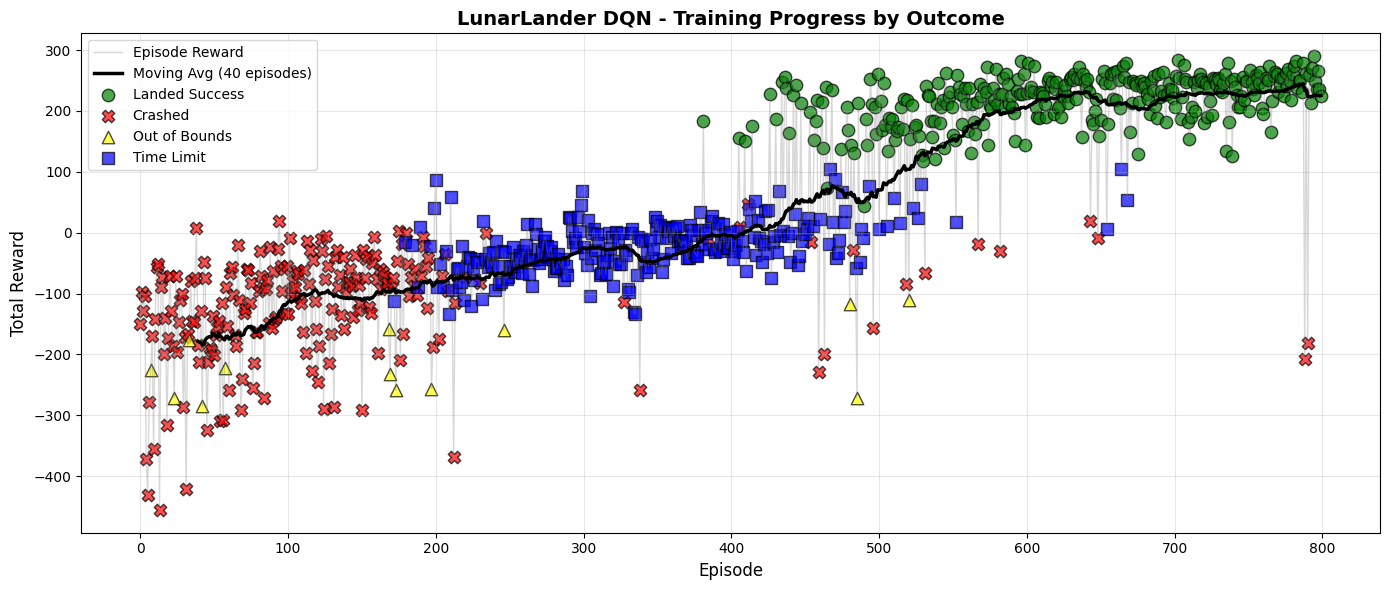


📊 Training Statistics:
  Average Reward: 44.784
  Max Reward: 290.299
  Min Reward: -455.638
  Std Dev: 158.418


In [41]:
# Plot episode rewards over time with outcome colors and different markers
fig, ax = plt.subplots(figsize=(14, 6))

# Base line plot
ax.plot(episode_rewards, alpha=0.3, label='Episode Reward', linewidth=1, color='gray')

# Plot moving average
window = 40
moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
ax.plot(range(window-1, len(episode_rewards)), moving_avg, linewidth=2.5, 
         label=f'Moving Avg ({window} episodes)', color='black')

# Color and marker mapping for outcomes
outcome_styles = {
    'landed_success': {'color': 'green', 'marker': 'o', 'label': 'Landed Success'},
    'crashed': {'color': 'red', 'marker': 'X', 'label': 'Crashed'},
    'out_of_bounds': {'color': 'yellow', 'marker': '^', 'label': 'Out of Bounds'},
    'time_limit': {'color': 'blue', 'marker': 's', 'label': 'Time Limit'}
}

# Plot scatter points with different markers for each outcome
for outcome, style in outcome_styles.items():
    episodes = [i for i, o in enumerate(episode_outcomes) if o == outcome]
    rewards = [episode_rewards[i] for i in episodes]
    ax.scatter(episodes, rewards, c=style['color'], marker=style['marker'], 
              label=style['label'], s=80, alpha=0.7, edgecolors='black', linewidth=1)

ax.set_xlabel('Episode', fontsize=12)
ax.set_ylabel('Total Reward', fontsize=12)
ax.set_title('LunarLander DQN - Training Progress by Outcome', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📊 Training Statistics:")
print(f"  Average Reward: {np.mean(episode_rewards):.3f}")
print(f"  Max Reward: {np.max(episode_rewards):.3f}")
print(f"  Min Reward: {np.min(episode_rewards):.3f}")
print(f"  Std Dev: {np.std(episode_rewards):.3f}")

## Watch Trained Agent in Action

In [42]:
from gymnasium.wrappers import RecordVideo
from IPython.display import HTML
import glob
import gymnasium as gym

env = gym.make("LunarLander-v3", render_mode="rgb_array")
env = RecordVideo(
    env,
    video_folder="videos",
    episode_trigger=lambda episode_id: True,
    name_prefix="trained_agent"
)

obs, info = env.reset()

final_reward = 0.0
terminated = False
truncated = False
episode_steps = 0
final_obs = obs
last_step_reward = 0.0  # ✅ NEW: needed for outcome

agent.set_epsilon(0.0)  # exploit only

while not (terminated or truncated):
    action = agent.act(obs)
    obs, reward, terminated, truncated, info = env.step(action)

    final_reward += reward
    episode_steps += 1
    final_obs = obs
    last_step_reward = reward  # ✅ NEW: keep last step reward

env.close()

# ✅ Categorize episode outcome (correct args)
outcome = categorize_episode_outcome(
    final_obs,
    episode_steps,
    last_step_reward
)
outcome_icon = get_outcome_icon(outcome)

print(f"\n🎬 Trained Agent Performance:")
print(f" Total Reward: {final_reward:.3f}")
print(f" Episode Steps: {episode_steps}")
print(f" Outcome: {outcome_icon} {outcome.replace('_', ' ').title()}")

# pick the newest video (avoids grabbing an older mp4)
video_path = max(glob.glob("videos/*.mp4"), key=lambda p: p)

HTML(f"""
<video width="600" controls autoplay loop>
    <source src="{video_path}" type="video/mp4">
</video>
""")


c:\DataScience_Unitn\Lunar_Lander_Reinforcement_Learning\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at c:\DataScience_Unitn\Lunar_Lander_Reinforcement_Learning\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


c:\DataScience_Unitn\Lunar_Lander_Reinforcement_Learning\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at c:\DataScience_Unitn\Lunar_Lander_Reinforcement_Learning\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(



🎬 Trained Agent Performance:
 Total Reward: 238.487
 Episode Steps: 485
 Outcome: 🟢 Landed Success
